# HW FDTD 4: Time to Frequency Domain 


peak ((1000,), (1000,))


[ Info: Saved animation to /home/vlsh/Source/ECE 6340/E_wave.gif


Plots.AnimatedGif("/home/vlsh/Source/ECE 6340/E_wave.gif")
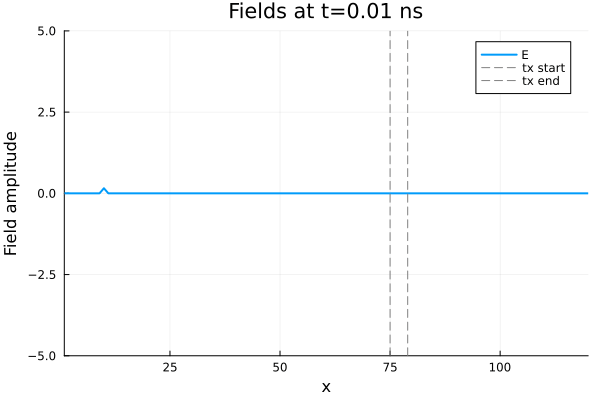

In [411]:
using Plots
using FFTW
gr()

# --------------------------------------------------------------------------- #
# Physical constants
# --------------------------------------------------------------------------- #
μ0 = 4π * 1e-7      # H/m
ϵ0 = 8.85e-12      # F/m
c  = 3e8           # m/s

# --------------------------------------------------------------------------- #
# Simulation parameters
# --------------------------------------------------------------------------- #
f = 2e9            # source frequency, Hz
ω = f*2*pi
λ = c / f          # wavelength in air, m
N = 120            # number of E nodes
Nt = 1000          # time steps
dx = λ / 20        # grid spacing, m
dt = dx / (2c)     # time step (Courant)

# --------------------------------------------------------------------------- #
# Material: air → quarter-wave transformer → medium
# --------------------------------------------------------------------------- #
ϵr_medium = 4.0
ϵr_qTX    = sqrt(ϵr_medium)           # impedance match: η_tx = √(η₀ η_medium)
λ_qTX     = λ / sqrt(ϵr_qTX)          # wavelength in transformer
n_cells_qtx = max(1, round(Int, (λ_qTX/4) / dx))
layer_start  = 75
layer_end_qtx = layer_start + n_cells_qtx - 1

ϵ = fill(ϵ0, N)
for i in layer_start:N
    ϵ[i] = ϵr_medium * ϵ0
end

# # Quarter-wave matching layer
# for i in layer_start:layer_end_qtx
#     ϵ[i] = ϵr_qTX * ϵ0
# end

# --------------------------------------------------------------------------- #
# Fields and Mur BC coefficients
# --------------------------------------------------------------------------- #
H = zeros(N)
E = zeros(N)
E_old = zeros(N)

v_medium   = c / sqrt(ϵr_medium)
coef_left  = (c*dt - dx) / (c*dt + dx)
coef_right = (v_medium*dt - dx) / (v_medium*dt + dx)
#coef_right = coef_left;

# Probe 
PROBE_POS = 45
E_probe = zeros(Nt)

peak_E = 0

# --------------------------------------------------------------------------- #
# Time stepping and animation
# --------------------------------------------------------------------------- #
anim = @animate for iter in 1:Nt
    E_old .= E

    # H update
    for x in 1:N-1
        H[x] += (dt / (μ0*dx)) * (E[x] - E[x+1])
    end

    # E update
    for x in 2:N
        E[x] += (dt / (ϵ[x]*dx)) * (H[x-1] - H[x])
    end

    # peak detection
    #global peak_E = max(E[PROBE_POS], peak_E)

    # Soft source
    E[10] += sin(iter * dt * 2π * f)

    # Mur ABCs
    E[1] = E_old[2]   + coef_left  * (E[2]   - E_old[1])
    E[N] = E_old[N-1] + coef_right * (E[N-1] - E_old[N])

    # Plot
    plot(1:N, E;
        xlim=(1, N), ylim=(-5, 5), lw=2, label="E",
        title="Fields at t=$(round(iter*dt*1e9, digits=2)) ns",
        xlabel="x", ylabel="Field amplitude")
    vline!([layer_start],      color=:gray, ls=:dash, label="tx start")
    vline!([layer_end_qtx+1],  color=:gray, ls=:dash, label="tx end")

    E_probe[iter] = E[PROBE_POS]
end

function run_sim(with_wall::Bool)

    E .= 0.0
    H .= 0.0

    # reset material
    ϵ .= ϵ0

    if with_wall
        ϵ[layer_start:layer_end_qtx] .= 4ϵ0   # example dielectric wall
    end

    E_probe = zeros(Nt)

    for iter in 1:Nt

        E_old .= E

        # --- H update ---
        for x in 1:N-1
            H[x] += (dt / (μ0*dx)) * (E[x] - E[x+1])
        end

        # --- E update ---
        for x in 2:N
            E[x] += (dt / (ϵ[x]*dx)) * (H[x-1] - H[x])
        end

        # --- Soft source ---
        E[10] += sin(iter * dt * 2π * f)

        # --- Mur ABC ---
        E[1] = E_old[2]   + coef_left  * (E[2]   - E_old[1])
        E[N] = E_old[N-1] + coef_right * (E[N-1] - E_old[N])

        # --- Record probe ---
        E_probe[iter] = E[PROBE_POS]
    end

    return E_probe
end

E_probe = run_sim(true);
E_probe_incedent = run_sim(false);


#println("peak $(peak_E)");
println("peak $((size(E_probe), size(E_probe_incedent)))");

gif(anim, "E_wave.gif", fps=20)




In [412]:
# Clear non-steady state samples
E_probe = E_probe[Int(floor(4e-9/dt)):end]
E_probe_incedent = E_probe_incedent[Int(floor(4e-9/dt)):end]
#E_probe = E_probe[Int(0):end]
# Update Nt - the number of samples
Nt = length(E_probe)

681

In [413]:
# -----------------------------
# using peak detection
# -----------------------------
for iter in 1:Nt
    # peak detection
    global peak_E = max(E_probe[iter], peak_E)
end
println("peak $(peak_E)");

peak 0.7178180840008401


In [414]:
# using Pkg;
# Pkg.add("FFTW");

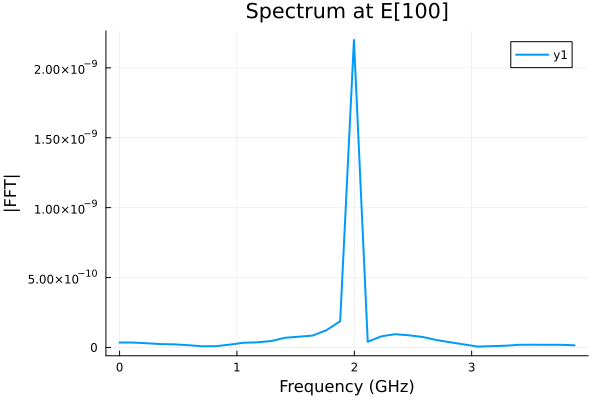

In [415]:
# -----------------------------
# FFT of probe signal
# -----------------------------
using FFTW

Y = fft(E_probe)
freq = (0:Nt-1) .* (1/(Nt*dt))   # frequency axis (Hz)

# Single-sided spectrum
half = 1:div(Nt,20)
Y_half = Y[half]*dt
freq_half = freq[half]

# Plot magnitude
plot(freq_half .* 1e-9, abs.(Y_half);
    xlabel="Frequency (GHz)",
    ylabel="|FFT|",
    title="Spectrum at E[100]",
    lw=2)

# Plot magnitude
# plot(freq .* 1e-9, abs.(Y);
#     xlabel="Frequency (GHz)",
#     ylabel="|FFT|",
#     title="Spectrum at E[100]",
#     lw=2)

In [416]:
# Plot magnitude
# plot(freq_half .* 1e-9, angle.(Y_half)*180;
#     xlabel="Frequency (GHz)",
#     ylabel="|FFT|",
#     title="Spectrum at E[100]",
#     lw=2)
# angle.(Y_half)*180

In [417]:
# Using DFT
#Nt = length(E_probe)
X = zeros(ComplexF64, Nt)

for k in 1:Nt
    for n in 1:Nt
        X[k] += E_probe[n] * exp(-1im * 2π * (k-1)*(n-1)/Nt)
    end
end


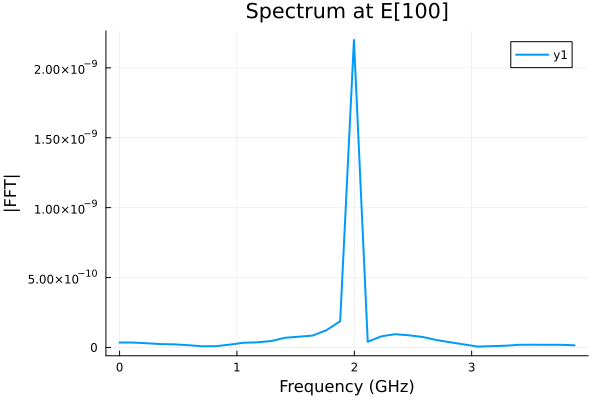

In [418]:
# Single-sided spectrum
half = 1:div(Nt,20)
X_half = X[half]*dt
freq_half = freq[half]

plot(freq_half.* 1e-9, abs.(X_half);
    xlabel="Frequency (GHz)",
    ylabel="|FFT|",
    title="Spectrum at E[100]",
    lw=2)

In [419]:
# Two equations two unknows
t1 = 8e-9 # s
t2 = 8.5e-9 # s
n1 = Int(floor(t1/dt))
n2 = Int(floor(t2/dt))
q1 = E_probe[n1]
q2 = E_probe[n2]
θ = atan( (q2*sin(ω*t1) - q1*sin(ω*t2) )/(q1*cos(ω*t2) - q1*cos(ω*t1) ) )
A = abs(q1/(sin(ω*t1 + θ)))

println("Amplitude  $(A),  Phase $(θ)");

Amplitude  0.4979865136778395,  Phase 1.5707963267948966


In [420]:
# Find complex reflected field
Xc = fft(E_probe)
Xc_inc = fft(E_probe_incedent)
(size(Xc_inc), size(Xc))
Xc_reflected = Xc - Xc_inc  

681-element Vector{ComplexF64}:
 -2.2740222214619257 - 3.497202527569243e-15im
  -2.074557763190203 + 0.6238209284709009im
 -1.3237438273373858 + 0.6919347617460319im
 -1.2044606307249193 + 0.15396980940000216im
  -1.304567975563072 - 0.13280449513365555im
 -1.8019586877945097 - 1.1080195234823016im
 -3.5514541319156487 - 0.961320936027435im
  -4.582157486769928 + 0.05572259621228548im
   -5.51618745662262 + 0.8590560757531023im
  -6.848091131250677 + 3.1385122238700705im
  -6.197468858807131 + 5.511522917140447im
  -5.519307725233192 + 7.191180033369612im
  -4.881874088185121 + 9.75933521811013im
                     ⋮
  -4.881874088185112 - 9.759335218110138im
   -5.51930772523319 - 7.191180033369611im
   -6.19746885880713 - 5.511522917140439im
   -6.84809113125067 - 3.138512223870068im
  -5.516187456622633 - 0.8590560757531029im
  -4.582157486769949 - 0.05572259621226905im
  -3.551454131915655 + 0.9613209360274257im
 -1.8019586877945084 + 1.1080195234823034im
 -1.3045679755630704 + 

In [421]:
f_target = 2e9
k = argmin(abs.(freq .- f_target))
A = 2*(abs(Xc_reflected[k]) / Nt)
θ = angle(Xc_reflected[k])
println("Amplitude  $(A),  Phase $(θ)");


Amplitude  0.806405803281453,  Phase -3.0230170378952006


In [422]:
Γ = Xc_reflected ./ Xc_inc
abs.(Γ[k])

0.610311424293403